In [1]:
import os
import sys
import json
import h5py
import glob
import numpy as np
import tensorflow as tf
import scipy.stats
import functools
import pdb

%matplotlib inline
import matplotlib.pyplot as plt

import pitchnet_evaluate_best

sys.path.append('assets_psychophysics')
import util_human_model_comparison
import util_figures_psychophysics

sys.path.append('/packages/tfutil')
import functions_brain_network
import functions_graph_assembly as fga

sys.path.append('/packages/msutil')
import util_figures
import util_figures_cnn
import util_stimuli
import util_misc


In [ ]:
fn_brain_arch = '/saved_models/arch_search_v02_topN/f0_label_192/arch_0302/brain_arch.json'
with open(fn_brain_arch, 'r') as f:
    list_brain_arch = json.load(f)


In [ ]:
tf.reset_default_graph()

input_shape = [1, 100, 1000, 1]
input_tensor = tf.placeholder(tf.float32, shape=input_shape, name='input_tensor')
output_tensor, nets = functions_brain_network.make_brain_net(
    input_tensor,
    {'f0_label': 700},
    list_brain_arch)


In [ ]:
tf.reset_default_graph()

input_shape = [1, 1, 4800, 1]
input_tensor = tf.placeholder(tf.float32, shape=input_shape, name='input_tensor')

list_brain_arch_tmp = [
    {
        'args': {
            'name': 'coch_slice_0',
            'begin': [0, 0, 2160, 0],
            'size': [-1, -1, 2400, -1],
        },
        'layer_type': 'tf.slice'
    },
    {
        'args': {
            'activation': None,
            'dilation_rate': [1, 1],
            'filters': 100,
            'kernel_size': [1, 801],
            'name': 'coch_conv_0',
            'padding': 'VALID',
            'strides': [1, 1]
        },
        'layer_type': 'tf.layers.conv2d'
    },
    {
        'args': {
            'name': 'coch_transpose_0',
            'perm': [0, 3, 2, 1]
        },
        'layer_type': 'tf.transpose'
    },
    {
        "args": {
            "name": "coch_relu_0"
        },
        "layer_type": "tf.nn.relu"
    },
    {
        "args": {
            "name": "coch_tfnnresample_0",
            "sr_input": 32e3,
            "sr_output": 20e3,
            "kwargs_nnresample_poly_filter": {
                "down": 4,
                "up": 1
            },
        },
        "layer_type": "tfnnresample"
    },
    {
        "args": {
            "name": "coch_relu_1"
        },
        "layer_type": "tf.nn.relu"
    },
]

list_brain_arch_tmp = list_brain_arch_tmp + list_brain_arch

output_tensor, nets = functions_brain_network.make_brain_net(
    input_tensor,
    {'f0_label': 700},
    list_brain_arch_tmp)

output_tensor, nets


In [ ]:
regex_fn = '/om/scratch/*/msaddler/data_pitchnet/PND_v08/noise_TLAS_snr_neg10pos10/PND_*.hdf5'
list_fn = glob.glob(regex_fn)
fn = list_fn[0]
# for k in util_misc.get_hdf5_dataset_key_list(fn):
#     print(k)

with h5py.File(fn, 'r') as f:
    IDX = -50
    idx0 = f['nopad_start_index'][IDX] - f['segment_start_index'][IDX]
    idx1 = f['nopad_end_index'][IDX] - f['segment_end_index'][IDX]
    
    print(f['f0'][IDX], f['nopad_f0_mean'][IDX])
    print(f['stimuli/signal_in_noise'][IDX, idx0:idx1].shape[0] / f['sr'][0])
    print(idx0, idx1)
    
    print(f['stimuli/signal_in_noise_dBSPL'][IDX])


In [ ]:
list_fn =[
    '/om/user/msaddler/data_pitchnet/bernox2005/lowharm_v01/stim.hdf5',
    '/om/user/msaddler/data_pitchnet/mooremoore2003/freqshifted_v01/stim.hdf5',
    '/om/user/msaddler/data_pitchnet/moore1985/mistunedharm_v01/stim.hdf5',
    '/om/user/msaddler/data_pitchnet/oxenham2004/transposedtones_v01/stim.hdf5',
    '/om/user/msaddler/data_pitchnet/shackcarl1994/altphase_v01/stim.hdf5',
    '/om/user/msaddler/data_pitchnet/bernox2005/exact_v00/stim.hdf5',
    '/om/user/msaddler/data_pitchnet/bernox2005/exact_v01/stim.hdf5',
]
for fn in list_fn:
    list_k = util_misc.get_hdf5_dataset_key_list(fn)
    fn_new = fn.replace('.hdf5', '_waveform.hdf5')
    with h5py.File(fn, 'r') as f:
        print('###', fn)
        print('###', fn_new)
        list_candidate_signal_k = [k for k in list_k if f[k].shape[-1] == 4800]
        list_other_k = [k for k in list_k if not f[k].shape[-1] == 4800]
        if len(list_candidate_signal_k) > 1:
            list_candidate_signal_k = [k for k in list_candidate_signal_k if 'noise' in k]
        assert len(list_candidate_signal_k) == 1
        
        assert not fn_new == fn
#         with h5py.File(fn_new, 'w') as f_new:
#             for k in list_other_k:
#                 f_new.create_dataset(k, data=f[k][:])
#             f_new.create_dataset('stimuli/signal_in_noise', data=f[list_candidate_signal_k[0]][:])
#             print(f_new['stimuli/signal_in_noise'])


In [ ]:
import os
import sys
import json
import glob
import copy
import collections
import re
import numpy as np
import importlib

sys.path.append('/packages/tfutil')
import functions_parameter_handling
importlib.reload(functions_parameter_handling)

list_brain_arch_prepend = [
    {
        'args': {
            'name': 'coch_slice_0',
            'begin': [0, 0, 2160, 0],
            'size': [-1, -1, 2400, -1],
        },
        'layer_type': 'tf.slice'
    },
    {
        'args': {
            'activation': None,
            'dilation_rate': [1, 1],
            'filters': 100,
            'kernel_size': [1, 801],
            'name': 'coch_conv_0',
            'padding': 'VALID',
            'strides': [1, 1]
        },
        'layer_type': 'tf.layers.conv2d'
    },
    {
        'args': {
            'name': 'coch_transpose_0',
            'perm': [0, 3, 2, 1]
        },
        'layer_type': 'tf.transpose'
    },
    {
        "args": {
            "name": "coch_relu_0"
        },
        "layer_type": "tf.nn.relu"
    },
    {
        "args": {
            "name": "coch_tfnnresample_0",
            "sr_input": 32e3,
            "sr_output": 20e3,
            "kwargs_nnresample_poly_filter": {
                "down": 8,
                "up": 5,
                "window_length": 161
            },
        },
        "layer_type": "tfnnresample"
    },
    {
        "args": {
            "name": "coch_relu_1"
        },
        "layer_type": "tf.nn.relu"
    },
]


regex_src_dir = '/saved_models/arch_search_v02_topN/TEMPLATE/arch_0???'
list_src_dir = glob.glob(regex_src_dir)

for src_dir in list_src_dir:
    dst_dir = src_dir.replace('TEMPLATE', 'cochlearn_PND_v08inst_noise_TLAS_snr_neg10pos10')
    fn_src_config = os.path.join(src_dir, 'config.json')
    fn_src_arch = os.path.join(src_dir, 'brain_arch.json')
    fn_dst_config = os.path.join(dst_dir, 'config.json')
    fn_dst_arch = os.path.join(dst_dir, 'brain_arch.json')
    if not os.path.exists(dst_dir):
        os.mkdir(dst_dir)
    
    with open(fn_src_config, 'r') as f:
        CONFIG = json.load(f)
    
    CONFIG['signal_rate'] = 32e3
    CONFIG['BRAIN_PARAMS'].pop('save_pckl_path')
    CONFIG['ITERATOR_PARAMS']['feature_parsing_dict'].pop('nervegram_meanrates')
    CONFIG['ITERATOR_PARAMS']['feature_parsing_dict']['stimuli/signal_in_noise'] = {
        "dtype": "tf.float32",
        "shape": [4800]
    }
    CONFIG['ITERATOR_PARAMS']['feature_signal_path'] = 'stimuli/signal_in_noise'
    with open(fn_dst_config, 'w') as f:
        json.dump(CONFIG, f, indent=4, sort_keys=True)
    
    functions_parameter_handling.migrate_config_to_new_output_directory(
        fn_dst_config,
        dst_dir,
        force_overwrite=True)
    
    with open(fn_src_arch, 'r') as f:
        BRAIN_ARCH = json.load(f)
    
    BRAIN_ARCH = list_brain_arch_prepend + BRAIN_ARCH
#     with open(fn_dst_arch, 'w') as f:
#         json.dump(BRAIN_ARCH, f, indent=4, sort_keys=True)

# print(json.dumps(CONFIG, indent=4, sort_keys=True))
# print(json.dumps(BRAIN_ARCH, indent=4, sort_keys=True))


In [ ]:
output_directory = '/saved_models/arch_search_v02_topN/cochlearn/arch_0191'

config_fn = os.path.join(output_directory, 'config.json')
validation_metrics_fn = os.path.join(output_directory, 'validation_metrics.json')
with open(config_fn) as f:
    CONFIG = json.load(f)
ckpt_num = pitchnet_evaluate_best.get_best_checkpoint_number(
    validation_metrics_fn,
    metric_key='f0_label:accuracy',
    maximize=True,
    checkpoint_number_key='step')
    
ITERATOR_PARAMS = CONFIG['ITERATOR_PARAMS']
N_CLASSES_DICT = CONFIG['N_CLASSES_DICT']
BRAIN_PARAMS = CONFIG['BRAIN_PARAMS']

tf.reset_default_graph()
shape = ITERATOR_PARAMS['feature_parsing_dict'][ITERATOR_PARAMS['feature_signal_path']]['shape']
batch_subbands = tf.placeholder(tf.float32, shape=[None] + shape)
if len(batch_subbands.shape) == 2:
    batch_subbands = batch_subbands[:, tf.newaxis, :, tf.newaxis]
batch_out_dict, brain_container = fga.build_brain_graph(batch_subbands, N_CLASSES_DICT, **BRAIN_PARAMS)
init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
sess = tf.Session()
sess.run(init_op)
brain_var_scope = 'brain_network'
brain_ckpt_prefix_name = BRAIN_PARAMS.get('save_ckpt_path', 'brain_model.ckpt')
restore_model_path = os.path.join(output_directory, brain_ckpt_prefix_name + '-{}'.format(ckpt_num))
brain_globals = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=brain_var_scope)
brain_locals = tf.get_collection(tf.GraphKeys.LOCAL_VARIABLES, scope=brain_var_scope)
brain_variables =  brain_globals + brain_locals
saver_brain_net, out_ckpt_loc_brain_net, brain_net_ckpt = fga.build_saver(
    sess, brain_variables, output_directory,
    restore_model_path=restore_model_path,
    ckpt_prefix_name=brain_ckpt_prefix_name)

# for v in brain_variables:
#     print(v)
tf_var = brain_variables[0] # conv0 filter kernels
tf_var_value = np.transpose(np.squeeze(sess.run(tf_var)))
tf_var_name = tf_var.name
print(tf_var_name, tf_var_value.shape, tf_var_value.dtype)


In [ ]:
sr = 32e3
kernels = tf_var_value.copy()

t = np.arange(0, kernels.shape[1]) / sr * 1000

np.random.seed(4078)
list_kernel_idx = np.random.randint(low=0, high=kernels.shape[0], size=[5], dtype=int)
list_kernel_idx = np.sort(list_kernel_idx)
list_kernel_idx = [10, 30, 50, 70, 90]
nrows = len(list_kernel_idx)
ncols = 2

fig, ax_arr = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(2.7*ncols, 1.8*nrows))

for r_idx, kernel_idx in enumerate(list_kernel_idx):
    x = kernels[kernel_idx]
    
    fxx, pxx = util_stimuli.power_spectrum(x, sr)
    fxx = fxx
    pxx = pxx - pxx.max() + 40
    
    mag_spec = 2 * np.square(np.abs(np.fft.rfft(x) / len(x)))
    mag_spec_freqs = np.fft.rfftfreq(len(x), d=1/sr)
    centroid = np.sum(mag_spec * mag_spec_freqs) / np.sum(mag_spec)
#     ax_arr[r_idx, 1].axvline(x=centroid, color='r', lw=1.0, ls='--')

    ax_arr[r_idx, 0].plot(t, x, color='k', lw=0.3)
    ax_arr[r_idx, 1].plot(fxx, pxx, color='k', lw=0.3)
    kwargs_format_axes0 = {
        'str_xlabel': 'Time (ms)',
        'str_ylabel': 'Filter {:02d}'.format(kernel_idx),
        'str_title': None,
        'xticks': np.linspace(t[0], t[-1], 6),
        'xticklabels': None,
        'xlimits': [t[0], t[-1]],
        'ylimits': [-0.15, 0.15],
        'yticks': [],
        'yticklabels': [],
    }
#     kwargs_format_axes1 = {
#         'str_xlabel': 'Frequency (kHz)',
#         'str_ylabel': 'Gain (dB)',
#         'str_title': None,
#         'xticks': [0, 2, 4, 6, 8],
#         'xticklabels': None,
#         'xlimits': [0, 8],
#         'ylimits': [0, 45],
#         'yticks': [0, 15, 30, 45],
#         'yticklabels': None,
#     }
    kwargs_format_axes1 = {
        'str_xlabel': 'Frequency (Hz)',
        'str_ylabel': 'Gain (dB)',
        'str_title': None,
        'xticks_minor': [],
        'xticks': [125, 250, 500, 1e3, 2e3, 4e3, 8e3],
        'xticklabels': [125, '', 500, '', 2000, '', 8000],
        'xlimits': [125, 8e3],
        'ylimits': [0, 45],
        'yticks': [0, 15, 30, 45],
        'yticklabels': None,
        'xscale': 'log',
    }
    
    if r_idx < len(list_kernel_idx) - 1:
#         kwargs_format_axes0['xticklabels'] = []
        kwargs_format_axes0['str_xlabel'] = None
#         kwargs_format_axes1['xticklabels'] = []
        kwargs_format_axes1['str_xlabel'] = None
    
    ax_arr[r_idx, 0] = util_figures.format_axes(ax_arr[r_idx, 0], **kwargs_format_axes0)
    ax_arr[r_idx, 1] = util_figures.format_axes(ax_arr[r_idx, 1], **kwargs_format_axes1)
#     ax_arr[r_idx, 1].yaxis.tick_right()
#     ax_arr[r_idx, 1].yaxis.set_label_position('right')
plt.tight_layout()
plt.show()

# save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2021_05_07_pitchnet_paper_figures_v04'
# save_fn = os.path.join(save_dir, 'neurophysiology_cochlearn_example_kernels_arch_0191_cochlearn.pdf')
# fig.savefig(save_fn, bbox_inches='tight', pad_inches=0.1, transparent=True)
# print(save_fn)


In [2]:
# model_dir_regex = '/saved_models/arch_search_v02_topN/cochlearn_PND_v08spch_noise_TLAS_snr_neg10pos10/arch_0???'
# model_dir_regex = '/saved_models/arch_search_v02_topN/cochlearn_IHC4000Hz/arch_0???'
model_dir_regex = '/saved_models/arch_search_v02_topN/cochlearn/arch_0???'

sr = 32e3

model_dir_list = glob.glob(model_dir_regex)
model_vars_dict = {}

for model_dir in model_dir_list:
    config_fn = os.path.join(model_dir, 'config.json')
    validation_metrics_fn = os.path.join(model_dir, 'validation_metrics.json')
    with open(config_fn) as f:
        CONFIG = json.load(f)
    ckpt_num = pitchnet_evaluate_best.get_best_checkpoint_number(
        validation_metrics_fn,
        metric_key='f0_label:accuracy',
        maximize=True,
        checkpoint_number_key='step')
    ITERATOR_PARAMS = CONFIG['ITERATOR_PARAMS']
    N_CLASSES_DICT = CONFIG['N_CLASSES_DICT']
    BRAIN_PARAMS = CONFIG['BRAIN_PARAMS']

    tf.reset_default_graph()
    shape = ITERATOR_PARAMS['feature_parsing_dict'][ITERATOR_PARAMS['feature_signal_path']]['shape']
    batch_subbands = tf.placeholder(tf.float32, shape=[None] + shape)
    if len(batch_subbands.shape) == 2:
        batch_subbands = batch_subbands[:, tf.newaxis, :, tf.newaxis]
    batch_out_dict, brain_container = fga.build_brain_graph(batch_subbands, N_CLASSES_DICT, **BRAIN_PARAMS)
    init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
    sess = tf.Session()
    sess.run(init_op)
    brain_var_scope = 'brain_network'
    brain_ckpt_prefix_name = BRAIN_PARAMS.get('save_ckpt_path', 'brain_model.ckpt')
    restore_model_path = os.path.join(model_dir, brain_ckpt_prefix_name + '-{}'.format(ckpt_num))
    brain_globals = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=brain_var_scope)
    brain_locals = tf.get_collection(tf.GraphKeys.LOCAL_VARIABLES, scope=brain_var_scope)
    brain_variables =  brain_globals + brain_locals
    saver_brain_net, out_ckpt_loc_brain_net, brain_net_ckpt = fga.build_saver(
        sess,
        brain_variables,
        model_dir,
        restore_model_path=restore_model_path,
        ckpt_prefix_name=brain_ckpt_prefix_name)
    
    tf_var = brain_variables[0] # conv0 filter kernels
    tf_var_value = np.transpose(np.squeeze(sess.run(tf_var)))
    tf_var_name = tf_var.name
    model_vars_dict[model_dir] = tf_var_value


Selecting checkpoint 75000 (f0_label:accuracy=0.23124857246875763)
Loading brain network config from /saved_models/arch_search_v02_topN/cochlearn/arch_0083/brain_arch.json
Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
[tfnnresample] interpreting `tensor_input.shape` as [batch, freq, time, channels]
[tfnnresample] using up=5 rather than up=5 for nnresample_poly_filter
[tfnnresample] using down=8 rather than down=8 for nnresample_poly_filter
[tfnnresample] using cutoff frequency near 10000.0 Hz for anti-aliasing lowpass filter
Instructions for updating:
Use keras.layers.batch_normalization instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
### Loading va

[tfnnresample] using up=5 rather than up=5 for nnresample_poly_filter
[tfnnresample] using down=8 rather than down=8 for nnresample_poly_filter
[tfnnresample] using cutoff frequency near 10000.0 Hz for anti-aliasing lowpass filter
### Loading variables from specified checkpoint: /saved_models/arch_search_v02_topN/cochlearn/arch_0338/brain_model.ckpt-60000
INFO:tensorflow:Restoring parameters from /saved_models/arch_search_v02_topN/cochlearn/arch_0338/brain_model.ckpt-60000
Selecting checkpoint 90000 (f0_label:accuracy=0.28781718015670776)
Loading brain network config from /saved_models/arch_search_v02_topN/cochlearn/arch_0346/brain_arch.json
[tfnnresample] interpreting `tensor_input.shape` as [batch, freq, time, channels]
[tfnnresample] using up=5 rather than up=5 for nnresample_poly_filter
[tfnnresample] using down=8 rather than down=8 for nnresample_poly_filter
[tfnnresample] using cutoff frequency near 10000.0 Hz for anti-aliasing lowpass filter
### Loading variables from specified 

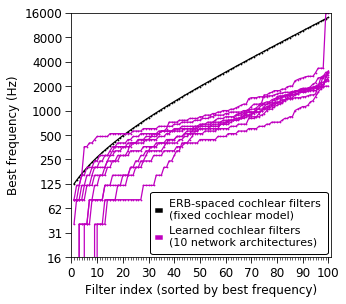

/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2021_05_07_pitchnet_paper_figures_v04/neurophysiology_cochlearn_best_frequencies.pdf


In [28]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.65, 4.5))
list_erb = util_stimuli.erbspace(125, 14e3, 100)
xvals = np.arange(0, list_erb.shape[0]) + 1
ax.plot(
    xvals,
    list_erb,
    color='k',
    marker='.',
    ls='-',
    lw=1.25,
    ms=1.50,
    label='ERB-spaced cochlear filters\n(fixed cochlear model)')

list_list_cf = []
for itr_model, model_dir in enumerate(model_dir_list):
    kernels = model_vars_dict[model_dir]
    list_cf = []

    for itr_kernel in range(kernels.shape[0]):
        y = kernels[itr_kernel]
        mag_spec = np.abs(np.fft.rfft(y) / len(y))
#         mag_spec = 2 * np.square(mag_spec)
        mag_spec_freqs = np.fft.rfftfreq(len(y), d=1/sr)
#         cf = np.sum(mag_spec * mag_spec_freqs) / np.sum(mag_spec)
        cf = mag_spec_freqs[np.argmax(mag_spec)]
        list_cf.append(cf)

    label = None
    if itr_model == 0:
        label = 'Learned cochlear filters\n(10 network architectures)'
    ax.plot(
        xvals,
        np.sort(list_cf),
        color='m',
        marker='.',
        ls='-',
        lw=1.25,
        ms=1.50,
        label=label)
    list_list_cf.append(np.sort(list_cf))

# list_list_cf = np.array(list_list_cf)
# yval, yerr = util_figures_psychophysics.combine_subjects(
#     list_list_cf, kwargs_bootstrap={})
# errorbar_kwargs = {
#     'yerr': yerr,
#     'fmt': 'none',
#     'ecolor': 'k',
#     'elinewidth': 0.5,
#     'capsize': 1.0,
# }
# ax.errorbar(np.arange(yval.shape[0]), yval, **errorbar_kwargs)
# ax.plot(np.arange(yval.shape[0]), yval, 'k.-', lw=2, ms=2, label='Mean ± SEM')


kwargs_legend = {
    'loc': 'lower right',
    'ncol': 1,
    'frameon': True,
    'framealpha': 1.0,
    'facecolor': 'w',
    'edgecolor': 'k',
    'handlelength': 0.3,
    'markerscale': 0,
    'fontsize': 11,
    'borderpad': 0.6,
    'borderaxespad': 0.3,
}
leg = ax.legend(**kwargs_legend)
for legobj in leg.legendHandles:
    legobj.set_linewidth(4.5)

yticks=[31.25/2, 31.25, 62.5, 125, 250, 500, 1000, 2000, 4000, 8000, 16000]
yticklabels = []
for itr_yt, yt in enumerate(yticks):
    if itr_yt % 2 == 0:
        yticklabels.append('{:.0f}'.format(yt))
    else:
        yticklabels.append('{:.0f}'.format(yt))
ax = util_figures.format_axes(
    ax,
    str_xlabel='Filter index (sorted by best frequency)',
    str_ylabel='Best frequency (Hz)',
    str_title=None,
    fontsize_labels=12,
    fontsize_ticks=12,
    fontweight_labels=None,
    xscale='linear',
    yscale='log',
    xlimits=[xvals[0] - 1, xvals[-1] + 1],
    ylimits=[yticks[0], yticks[-1]],
    xticks=np.arange(0, 101, 10),
    yticks=yticks,
    xticks_minor=xvals,
    yticks_minor=[],
    xticklabels=None,
    yticklabels=yticklabels,
    spines_to_hide=[],
    major_tick_params_kwargs_update={},
    minor_tick_params_kwargs_update={})
plt.show()

# save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2021_05_07_pitchnet_paper_figures_v04'
# save_fn = os.path.join(save_dir, 'neurophysiology_cochlearn_best_frequencies.pdf')
# fig.savefig(save_fn, bbox_inches='tight', pad_inches=0, transparent=True)
# print(save_fn)


(100, 2400, 3)

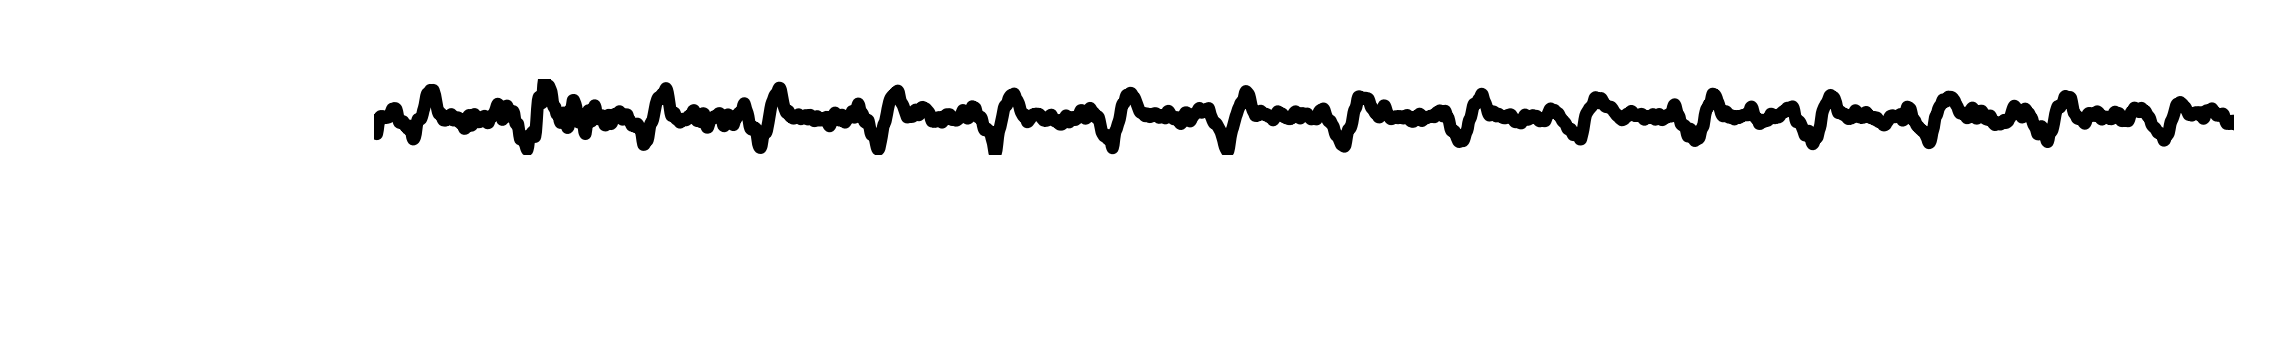

In [122]:
# Generate a picture of a waveform to use as the CNN input image in the schematic

fn = '/om/scratch/*/msaddler/data_pitchnet/PND_v08/noise_TLAS_snr_neg10pos10/PND_sr32000_v08_0000000-0021000.hdf5'
fn = glob.glob(fn)[0]
with h5py.File(fn, 'r') as f:
    IDX = 14184
    signal = f['stimuli/signal'][IDX]
    noise = f['stimuli/noise'][IDX]
    f0 = f['nopad_f0_mean'][IDX]
    sr = f['sr'][0]

snr = 10
dBSPL = 60
y = util_stimuli.combine_signal_and_noise(signal, noise, snr=snr)
y = util_stimuli.set_dBSPL(y, dBSPL)
y = y[1200:-1200]

dpi = 600
fig, ax = plt.subplots(figsize=(2400/dpi, 100/dpi), dpi=dpi)
ax.plot(y, color='k', lw=1.5)
ax.set_ylim([-np.abs(y).max(), np.abs(y).max()])
ax.set_xlim([0, len(y)-1])
ax.axis('off')

fig.tight_layout(pad=0)
ax.margins(0)

fig.canvas.draw()
image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
image_from_plot = image_from_plot.reshape(fig.canvas.get_width_height()[::-1] + (3,))
image_from_plot = np.array(image_from_plot)
image_from_plot.shape


[tfnnresample] interpreting `tensor_input.shape` as [batch, freq, time, channels]
[tfnnresample] using up=5 rather than up=5 for nnresample_poly_filter
[tfnnresample] using down=8 rather than down=8 for nnresample_poly_filter
[tfnnresample] using cutoff frequency near 10000.0 Hz for anti-aliasing lowpass filter


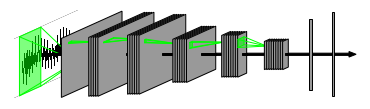

/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2021_05_07_pitchnet_paper_figures_v04/schematic_cnn_arch_0191_cochlearn_waveform.pdf


In [123]:
# CNN drawing on waveform input

import os
import sys
import json
import copy
import h5py
import glob
import numpy as np
import importlib

%matplotlib inline
import matplotlib.pyplot as plt

sys.path.append('/packages/tfutil')
import functions_brain_network

sys.path.append('/packages/msutil')
import util_stimuli
import util_figures_cnn
importlib.reload(util_figures_cnn)

brain_arch_fn = '/saved_models/arch_search_v02_topN/cochlearn/arch_0191/brain_arch.json'

layer_list = util_figures_cnn.process_cnn_layer_list(brain_arch_fn, input_shape=[1,1,4800,1])
layer_list[1]['shape_activations'] = [100, 1600, 2]
layer_list[1]['shape_kernel'] = [100, 801]

kwargs_polygon_kernel_update = {
    'fc': [0, 1, 0],
}

# sr = 32e3
# t = np.arange(0, 0.075, 1/sr)
# y = np.sin(2 * np.pi * 160 * t) + 0.25 * np.random.randn(t.shape[0])
# input_image = np.stack([y], axis=0)
input_image = np.mean(image_from_plot, axis=-1)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(1, 1))
ax = util_figures_cnn.draw_cnn_from_layer_list(
    ax,
    layer_list,
    deg_scale_x=60,
    deg_skew_y=30,
    scaling_w='log2',
    scaling_h='log2',
    scaling_n='log2',
    range_h=[0.75, np.inf],
    input_image=input_image,
    kwargs_polygon_kernel_update=kwargs_polygon_kernel_update)

[xb, yb, dxb, dyb] = ax.dataLim.bounds
fig_factor = 6
fig.set_size_inches(dxb/(fig_factor-1.2), dyb/fig_factor)

plt.show()

# save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2021_05_07_pitchnet_paper_figures_v04'
# save_fn = os.path.join(save_dir, 'schematic_cnn_arch_0191_cochlearn_waveform.pdf')
# fig.savefig(save_fn, bbox_inches='tight', pad_inches=0, transparent=True)
# print(save_fn)


In [7]:
def load_results_dict(results_dict_fn, pop_key_list=['psychometric_function']):
    with open(results_dict_fn) as f: results_dict = json.load(f)
    for pop_key in pop_key_list:
        if pop_key in results_dict.keys():
            results_dict.pop(pop_key)
    return results_dict

list_regex_model_dir = [
    '/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0???/',
    '/saved_models/arch_search_v02_topN/cochlearn/arch_0???/',
]

# Specify results_dict basenames for each experiment
experiment_to_basename_map = {
    'bernox2005': 'EVAL_SOFTMAX_lowharm_v01_bestckpt_results_dict.json',
    'transposedtones': 'EVAL_SOFTMAX_transposedtones_v01_bestckpt_results_dict.json',
    'freqshiftedcomplexes': 'EVAL_SOFTMAX_freqshifted_v01_bestckpt_results_dict.json',
    'mistunedharmonics': 'EVAL_SOFTMAX_mistunedharm_v01_bestckpt_results_dict.json',
    'altphasecomplexes': 'EVAL_SOFTMAX_altphase_v01_bestckpt_results_dict.json',
}

# Specify human_results_dict for each experiment
experiment_to_human_results_map = {
    'bernox2005': util_human_model_comparison.get_human_results_dict_bernox2005(),
    'transposedtones': util_human_model_comparison.get_human_results_dict_transposedtones(),
    'freqshiftedcomplexes': util_human_model_comparison.get_human_results_dict_freqshiftedcomplexes(),
    'mistunedharmonics': util_human_model_comparison.get_human_results_dict_mistunedharmonics(),
    'altphasecomplexes': util_human_model_comparison.get_human_results_dict_altphasecomplexes(),
}

experiment_to_compfunc_map = {
    'bernox2005': util_human_model_comparison.compare_bernox2005,
    'transposedtones': util_human_model_comparison.compare_transposedtones,
    'freqshiftedcomplexes': util_human_model_comparison.compare_freqshiftedcomplexes,
    'mistunedharmonics': util_human_model_comparison.compare_mistunedharmonics,
    'altphasecomplexes': util_human_model_comparison.compare_altphasecomplexes_hist,
}

experiment_to_compfunc_kwargs_map = {
    'bernox2005': {},
    'transposedtones': {},
    'freqshiftedcomplexes': {},
    'mistunedharmonics': {},
    'altphasecomplexes': {},
}

# Specify list of experiments to load
experiment_keys = [
    'bernox2005',
    'altphasecomplexes',
    'freqshiftedcomplexes',
    'mistunedharmonics',
    'transposedtones',
]


list_dict_metric_comparison = []
for regex_model_dir in list_regex_model_dir:
    list_model_dir = glob.glob(regex_model_dir)
    dict_metric_comparison = {key: [] for key in experiment_keys}
    for model_dir in list_model_dir:
        for key in experiment_keys:
            results_dict_fn = os.path.join(model_dir, experiment_to_basename_map[key])
            model_results_dict = load_results_dict(results_dict_fn)
            human_results_dict = experiment_to_human_results_map[key]
            compfunc = experiment_to_compfunc_map[key]
            compfunc_kwargs = experiment_to_compfunc_kwargs_map[key]
            metric_comparison = compfunc(human_results_dict, model_results_dict, **compfunc_kwargs)
            if len(np.array(metric_comparison).reshape([-1])) == 2:
                metric_comparison = metric_comparison[0]
            dict_metric_comparison[key].append(metric_comparison)
    list_dict_metric_comparison.append(dict_metric_comparison)


t(18)=5.2307, p=0.0001, d=-2.4658
t(18)=12.6941, p=0.0000, d=-5.9841
t(18)=2.6691, p=0.0156, d=-1.2582
t(18)=0.5872, p=0.5643, d=-0.2768
t(18)=2.0774, p=0.0524, d=-0.9793


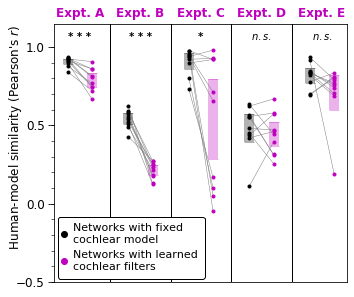

In [8]:
def cohend(x1, x2):
    n1 = len(x1)
    n2 = len(x2)
    v1 = np.var(x1)
    v2 = np.var(x2)
    return (np.mean(x2) - np.mean(x1)) / np.sqrt(((n1-1)*v1 + (n2-1)*v2) / (n1 + n2 - 2))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5.25, 4.75))

list_offset = [-0.2, 0.2]
list_color = ['k', 'm']
list_label = [
    'Networks with fixed\ncochlear model',
    'Networks with learned\ncochlear filters'
]

for itr_expt, key in enumerate(experiment_keys):
    list_yvals0 = np.array(list_dict_metric_comparison[0][key])
    list_yvals1 = np.array(list_dict_metric_comparison[1][key])
    x0 = itr_expt + list_offset[0]
    x1 = itr_expt + list_offset[1]
    for y0, y1 in zip(list_yvals0, list_yvals1):
        ax.plot([x0, x1], [y0, y1], color=[0.5]*3, lw=0.5, ls='-')
    
#     y0, yerr0 = util_figures_psychophysics.bootstrap(list_yvals0)
#     y1, yerr1 = util_figures_psychophysics.bootstrap(list_yvals1)
#     ax.plot([x0, x1], [y0 + 2 * yerr0, y1 + 2 * yerr1], color=[0.5]*3, lw=0.5, ls='--')
#     ax.plot([x0, x1], [y0 - 2 * yerr0, y1 - 2 * yerr1], color=[0.5]*3, lw=0.5, ls='--')

    transform = lambda x: scipy.stats.norm.ppf(x/2 + 1/2)
    t, p = scipy.stats.ttest_ind(transform(list_yvals0), transform(list_yvals1))
    d = cohend(transform(list_yvals0), transform(list_yvals1))
    print('t({})={:.4f}, p={:.4f}, d={:.4f}'.format(2*len(list_yvals0)-2, t, p, d))
    if p < 1e-3:
        p_str = '* * *'
    elif p < 1e-2:
        p_str = '* *'
    elif p < 5e-2:
        p_str = '*'
    else:
        p_str = '$n.s.$'.format(p)
#         p_str = '$p={:.3f}$'.format(p)
    ax.text(
        itr_expt,
        1.1,
        p_str,
        fontsize=10,
        fontweight='bold',
        horizontalalignment='center',
        verticalalignment='top')
    
    for itr_model, dict_metric_comparison in enumerate(list_dict_metric_comparison):
        offset = list_offset[itr_model]
        color = list_color[itr_model]
        if itr_expt == 0:
            label = list_label[itr_model]
        else:
            label = None
        list_yval = dict_metric_comparison[key]
        xval = itr_expt + offset
        yval, yerr = util_figures_psychophysics.bootstrap(np.array(list_yval))
        bar_kwargs = {
            'yerr': 2*yerr,
            'color': color,
            'capsize': 5,
            'ecolor': color,
            'linewidth': 10,
            'capthick': 1,
            'alpha': 0.3,
        }
        ax.errorbar(xval, yval, **bar_kwargs)
        point_xvals = np.linspace(xval-0.1, xval+0.1, len(list_yval))
        point_xvals = xval * np.ones_like(list_yval)
        ax.plot(
            point_xvals,
            list_yval,
            color=color,
            ls='',
            marker='.',
            ms=6,
            label=label)

xlimits = None
xticks = np.arange(len(experiment_keys))
xticklabels = ['Expt. A', 'Expt. B', 'Expt. C', 'Expt. D', 'Expt. E']
ax = util_figures.format_axes(
    ax,
    str_xlabel=None,
    str_ylabel="Human-model similarity (Pearson's $r$)",
    str_title=None,
    fontsize_labels=12,
    fontsize_ticks=12,
    fontweight_labels=None,
    xscale='linear',
    yscale='linear',
    xlimits=xlimits,
    ylimits=[-0.5, 1.15],
    xticks=xticks,
    yticks=np.arange(-0.5, 1.1, 0.5),
    xticks_minor=xticks[:-1] + 0.5,
    yticks_minor=np.arange(-0.5, 1.1, 0.1),
    xticklabels=xticklabels,
    yticklabels=None,
    spines_to_hide=[],
    major_tick_params_kwargs_update={},
    minor_tick_params_kwargs_update={})
ax.grid(which='minor', axis='x', color='k', lw=1)
ax.tick_params(which='major', axis='x', length=0)
ax.tick_params(which='minor', axis='x', length=0)
ax.set_ylabel("\tHuman-model similarity (Pearson's $r$)", labelpad=-8)

ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
ax.xaxis.set_tick_params(labelcolor='m')
[label.set_fontweight('bold') for label in ax.get_xticklabels()]

kwargs_legend = {
    'loc': 'lower left',
    'ncol': 1,
    'frameon': True,
    'framealpha': 1.0,
    'facecolor': 'w',
    'edgecolor': 'k',
    'handlelength': 0,
    'markerscale': 2.0,
    'fontsize': 11,
    'borderpad': 0.6,
    'borderaxespad': 0.3,
}
ax.legend(**kwargs_legend)
plt.show()

# save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2021_05_07_pitchnet_paper_figures_v04'
# save_fn = os.path.join(save_dir, 'psychophysics_human_model_correlation_cochlearn.pdf')
# fig.savefig(save_fn, bbox_inches='tight', pad_inches=0.01, transparent=True)
# print(save_fn)
